<a href="https://www.kaggle.com/code/robertmounce/my-own-spotify-wrap?scriptVersionId=189010877" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/music-data/StreamingHistory_music_1.json
/kaggle/input/music-data/Marquee.json
/kaggle/input/music-data/StreamingHistory_music_3.json
/kaggle/input/music-data/StreamingHistory_music_2.json
/kaggle/input/music-data/StreamingHistory_music_0.json


# Overview
## Insightful into my own patterns listening to music 


# Step 1 Import

In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2 EDA

In [3]:
# upload spotify marquee json files
files = '/kaggle/input/music-data/Marquee.json'
with open(files,'r') as file:
        data= json.load(file)
df = pd.json_normalize(data)

# upload listening history json files
file_paths =['/kaggle/input/music-data/StreamingHistory_music_0.json',
'/kaggle/input/music-data/StreamingHistory_music_1.json',
'/kaggle/input/music-data/StreamingHistory_music_2.json',
'/kaggle/input/music-data/StreamingHistory_music_3.json']
df_list =[]
for file_path in file_paths:
    with open(file_path, 'r') as file:
        data = json.load(file)
        df_list.append(pd.DataFrame(data))

In [4]:
df.head()

,artistName,segment
0,AJ Tracey,Light listeners
1,Masego,Previously Active Listeners
2,Joy Division,Previously Active Listeners
3,Sammy Johnson,Previously Active Listeners
4,John Barry,Previously Active Listeners


In [5]:
df.describe()

,artistName,segment
count,1365,1365
unique,1364,4
top,Dahi,Previously Active Listeners
freq,2,1146


In [6]:
df.dropna(subset=['artistName','segment'], inplace = True)
#Example: Standardize text to lower case
df['artistName'] = df['artistName'].str.lower()

In [7]:
segment_counts = df.groupby('segment')['artistName'].nunique()
print(segment_counts)

segment
Light listeners                 160
Moderate listeners               53
Previously Active Listeners    1146
Super Listeners                   6
Name: artistName, dtype: int64


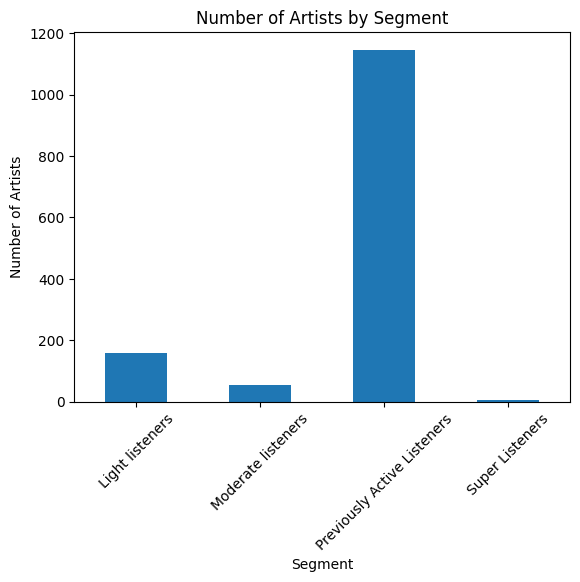

In [8]:
segment_counts.plot(kind='bar')
plt.title('Number of Artists by Segment')
plt.xlabel('Segment')
plt.ylabel('Number of Artists')
plt.xticks(rotation =45)
plt.show()

In [9]:
super_listeners_df =df[df['segment'] == 'Super Listeners']
print(super_listeners_df)

          artistName          segment
116              bas  Super Listeners
337              ilu  Super Listeners
509     brent faiyaz  Super Listeners
780   kendrick lamar  Super Listeners
832          j. cole  Super Listeners
1231           jay-z  Super Listeners


## Listening History
### Dataset Information
columns inclde the endtime including the date, the artname and trackname and ms played. 
### Cleaning tasks
- convert ms into minutes 
- count the tracks by the artists


In [10]:

        
streaming_history_df =pd.concat(df_list, ignore_index=True)
# Cleaning
streaming_history_df['endTime'] =pd.to_datetime(streaming_history_df['endTime'])
# Converting ms Msplayed to mintues 60000 ms per minute
streaming_history_df['minutesPlayed'] = streaming_history_df['msPlayed']/ 60000

In [11]:
streaming_history_df.head()

,endTime,artistName,trackName,msPlayed,minutesPlayed
0,2023-04-01 00:00:00,Brent Faiyaz,"GRAVITY (FEAT. TYLER, THE CREATOR)",2043,0.034050
1,2023-04-01 00:00:00,Joey Bada$$,Head High,8498,0.141633
2,2023-04-01 00:00:00,"Tyler, The Creator",Potato Salad,118750,1.979167
3,2023-04-01 00:03:00,"Tyler, The Creator",STUNTMAN (feat. Vince Staples),188197,3.136617
4,2023-04-01 00:04:00,"Tyler, The Creator","BOYFRIEND, GIRLFRIEND (2020 Demo) (feat. YG)",33459,0.557650


In [12]:
total_minutes_played = streaming_history_df['minutesPlayed'].sum()
print(f"Total minutes played: {total_minutes_played:.2f}")

Total minutes played: 59225.14


In [13]:
top_artists =streaming_history_df.groupby('artistName')['minutesPlayed'].sum().sort_values(ascending=False).head(10)
print(top_artists)

artistName
Drake                 2768.257017
Brent Faiyaz          2462.545400
Cleo Sol              1558.976933
Kendrick Lamar        1263.884867
J. Cole               1065.585850
Nas                    895.752750
Khamari                866.676933
Tyler, The Creator     827.715317
JAY-Z                  790.697900
Thee Sacred Souls      785.724617
Name: minutesPlayed, dtype: float64


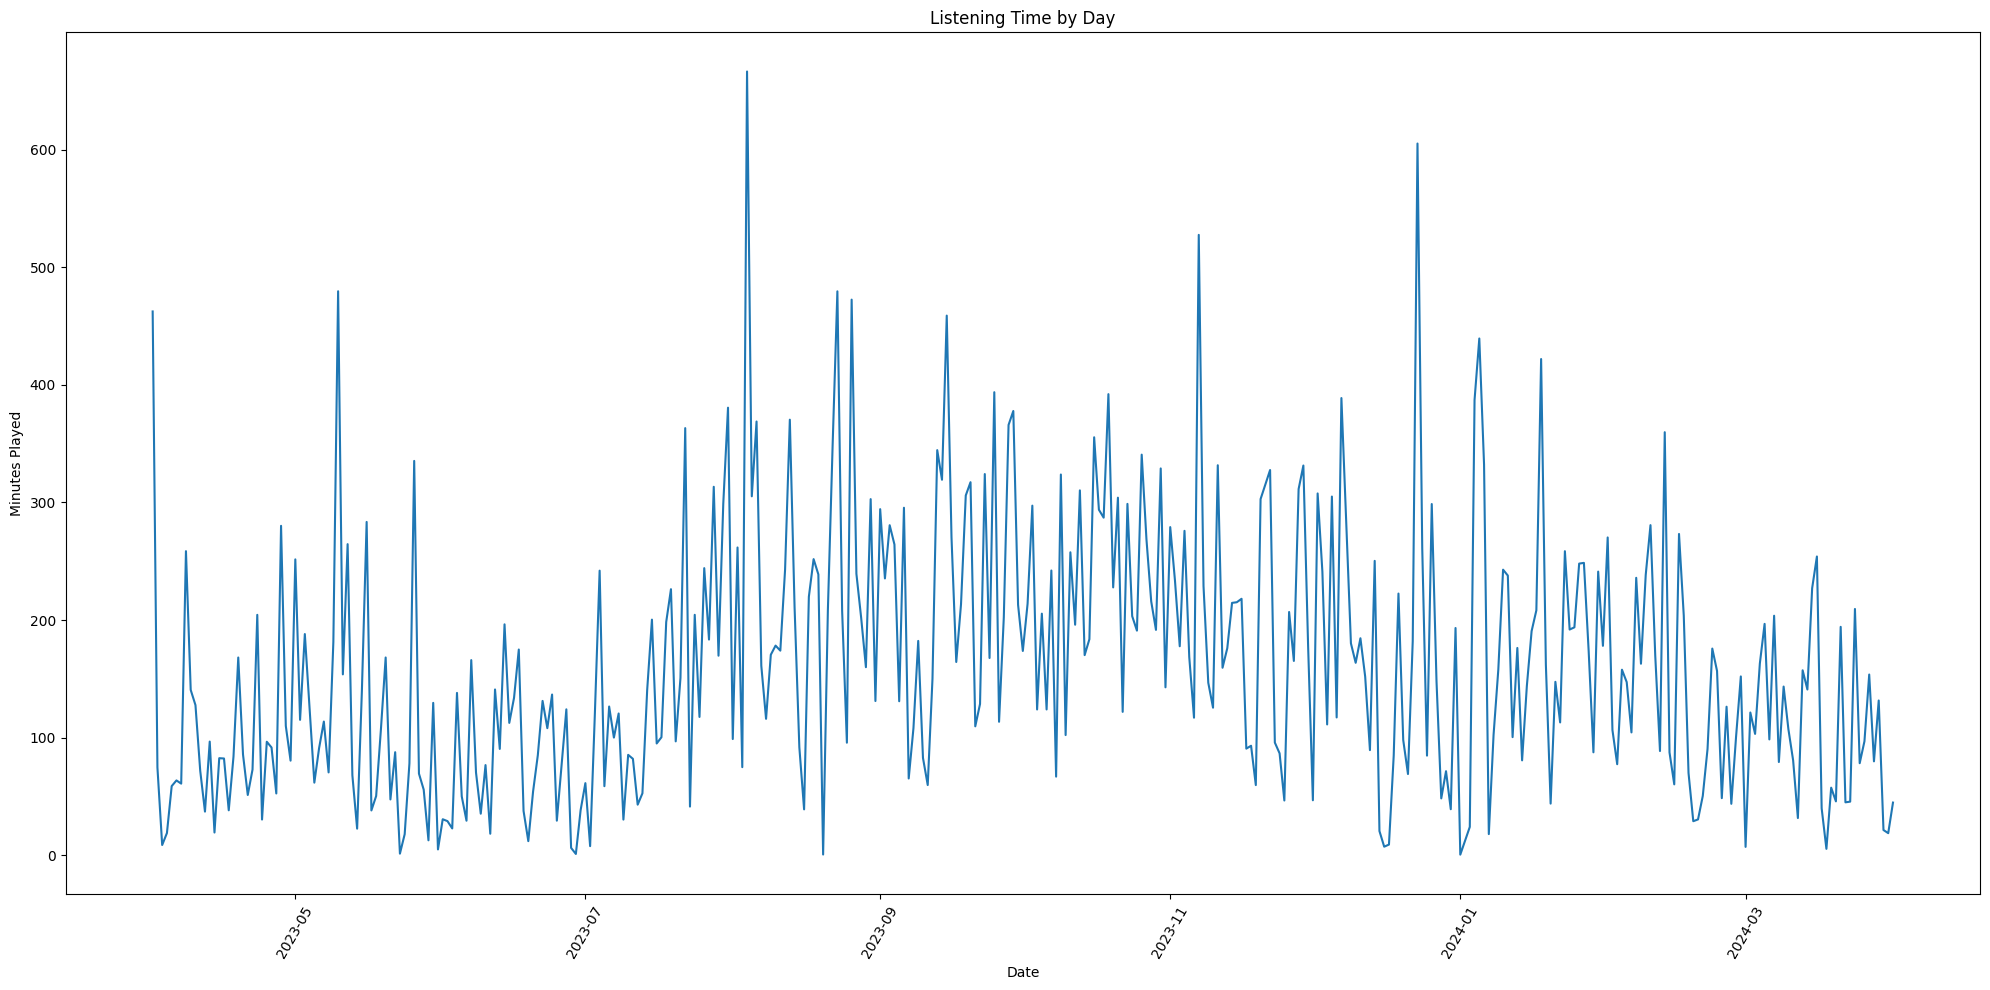

In [14]:
# Aggregate listening time by day
listening_by_day = streaming_history_df.groupby(streaming_history_df['endTime'].dt.date)['minutesPlayed'].sum()

# Plot
listening_by_day.plot(kind='line', figsize=(20, 10))
plt.title('Listening Time by Day')
plt.xlabel('Date')
plt.ylabel('Minutes Played')
plt.xticks(rotation=60)
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.show()


/tmp/ipykernel_18/2414130036.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  diversity_index_per_month = streaming_history_df.groupby('year_month').apply(lambda x: shannon_diversity_index(x['artistName']))


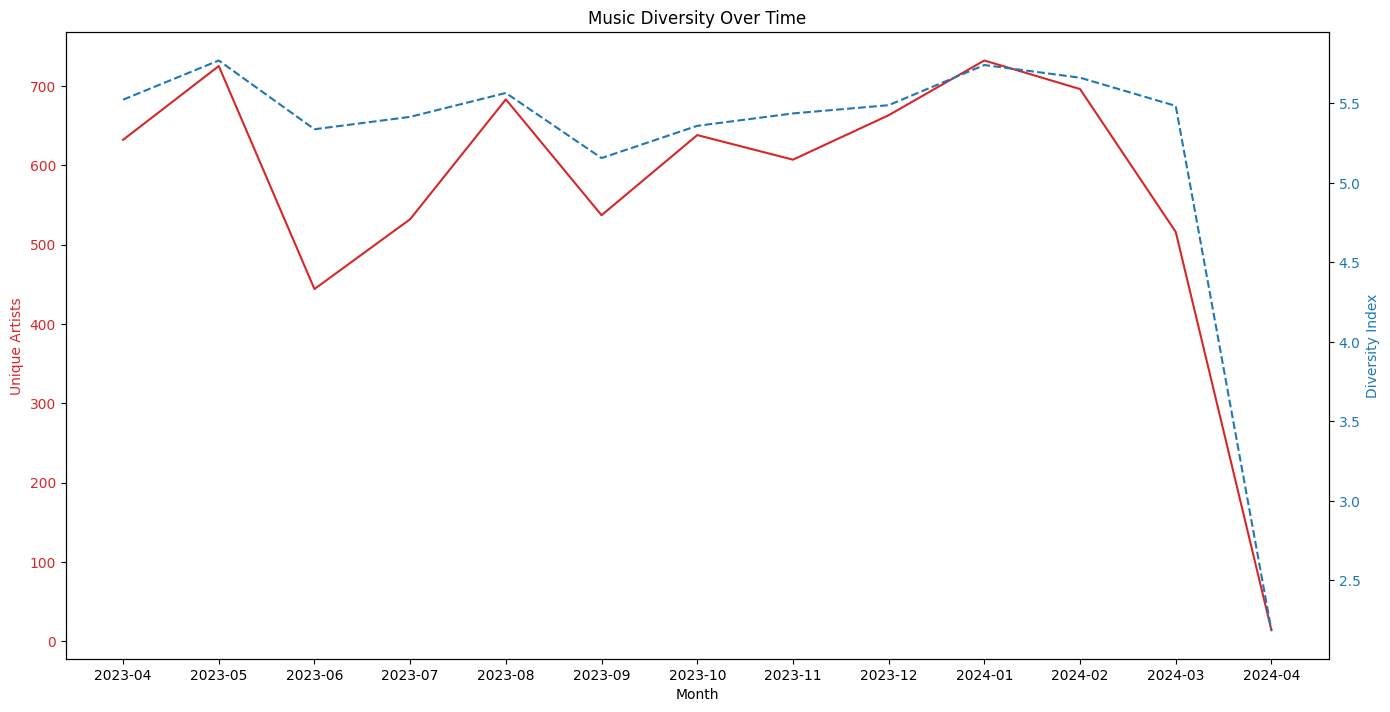

In [15]:
import numpy as np

# Assuming `streaming_history_df` is your DataFrame and 'endTime' has been converted to datetime

# Setting the month and year for endTime
streaming_history_df['year_month'] = streaming_history_df['endTime'].dt.to_period('M')

# Count unique artists and tracks per month
unique_artists_per_month = streaming_history_df.groupby('year_month')['artistName'].nunique()
unique_tracks_per_month = streaming_history_df.groupby('year_month')['trackName'].nunique()

# Calculate Shannon Diversity Index for artists per month
def shannon_diversity_index(series):
    proportions = series.value_counts(normalize=True)
    return -np.sum(proportions * np.log(proportions))

diversity_index_per_month = streaming_history_df.groupby('year_month').apply(lambda x: shannon_diversity_index(x['artistName']))

# Plotting
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 7))

color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Unique Artists', color=color)
ax1.plot(unique_artists_per_month.index.astype(str), unique_artists_per_month, color=color, label='Unique Artists')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Diversity Index', color=color)
ax2.plot(diversity_index_per_month.index.astype(str), diversity_index_per_month, color=color, linestyle='--', label='Diversity Index')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Music Diversity Over Time')
plt.show()


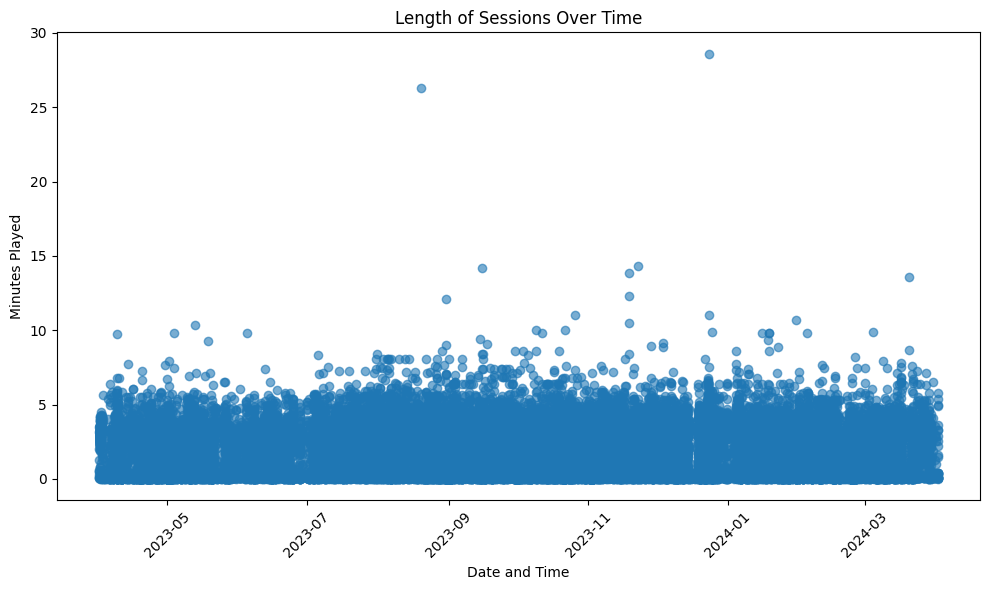

In [16]:
# Ensure 'endTime' is in datetime format and 'minutesPlayed' is calculated
# Convert 'msPlayed' to minutes if you haven't done so already
streaming_history_df['minutesPlayed'] = streaming_history_df['msPlayed'] / 60000

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(streaming_history_df['endTime'], streaming_history_df['minutesPlayed'], alpha=0.6)
plt.title('Length of Sessions Over Time')
plt.xlabel('Date and Time')
plt.ylabel('Minutes Played')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout for the x-axis labels

plt.show()


In [17]:
# Merging on 'artistName' to add 'segment' to the streaming history
merged_df = pd.merge(streaming_history_df, df, on='artistName', how='left')


In [18]:
# Aggregating minutes played by segment
segment_listen_minutes = merged_df.groupby('segment')['minutesPlayed'].sum().reset_index()

# Sorting to find the top segments
segment_listen_minutes = segment_listen_minutes.sort_values(by='minutesPlayed', ascending=False)

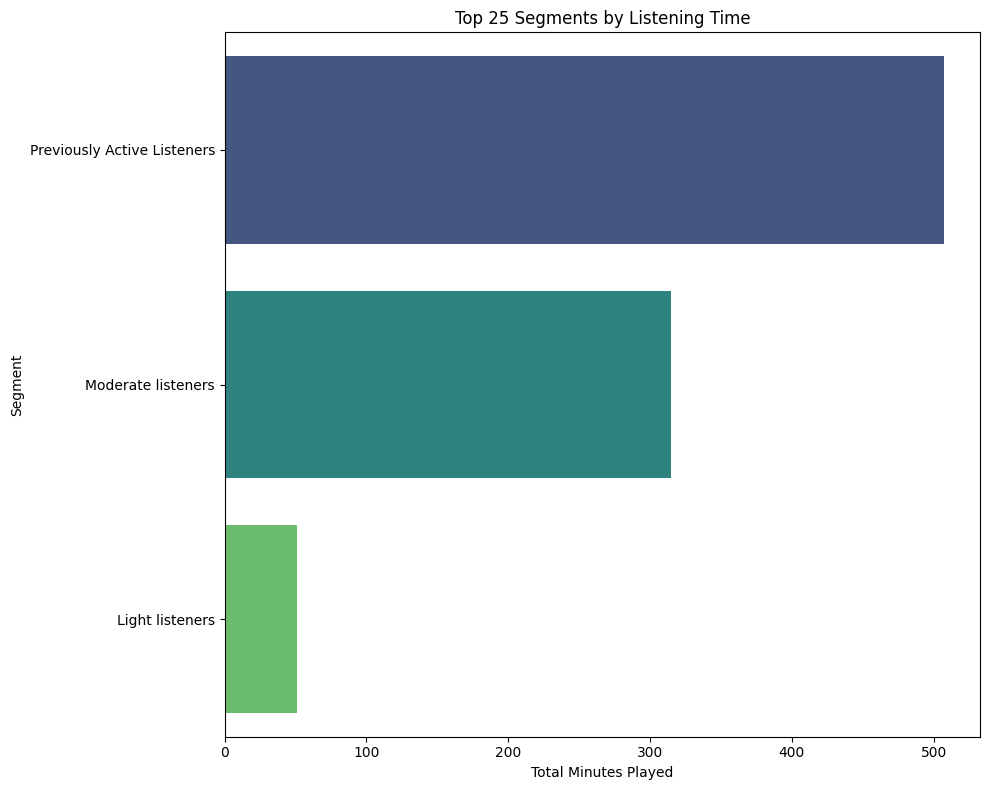

In [19]:
# Limiting to the top 25 segments
top_25_segments = segment_listen_minutes.head(25)

plt.figure(figsize=(10, 8))
sns.barplot(x='minutesPlayed', y='segment', data=top_25_segments, palette='viridis')
plt.title('Top 25 Segments by Listening Time')
plt.xlabel('Total Minutes Played')
plt.ylabel('Segment')
plt.tight_layout()
plt.show()

In [20]:
# Assuming 'merged_df' is your DataFrame after merging streaming history with segment information
previously_active = merged_df[merged_df['segment'] == 'Previously Active Listeners']

# Aggregating minutes listened for each artist in the segment
artist_listen_minutes = previously_active.groupby('artistName')['minutesPlayed'].sum().reset_index()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


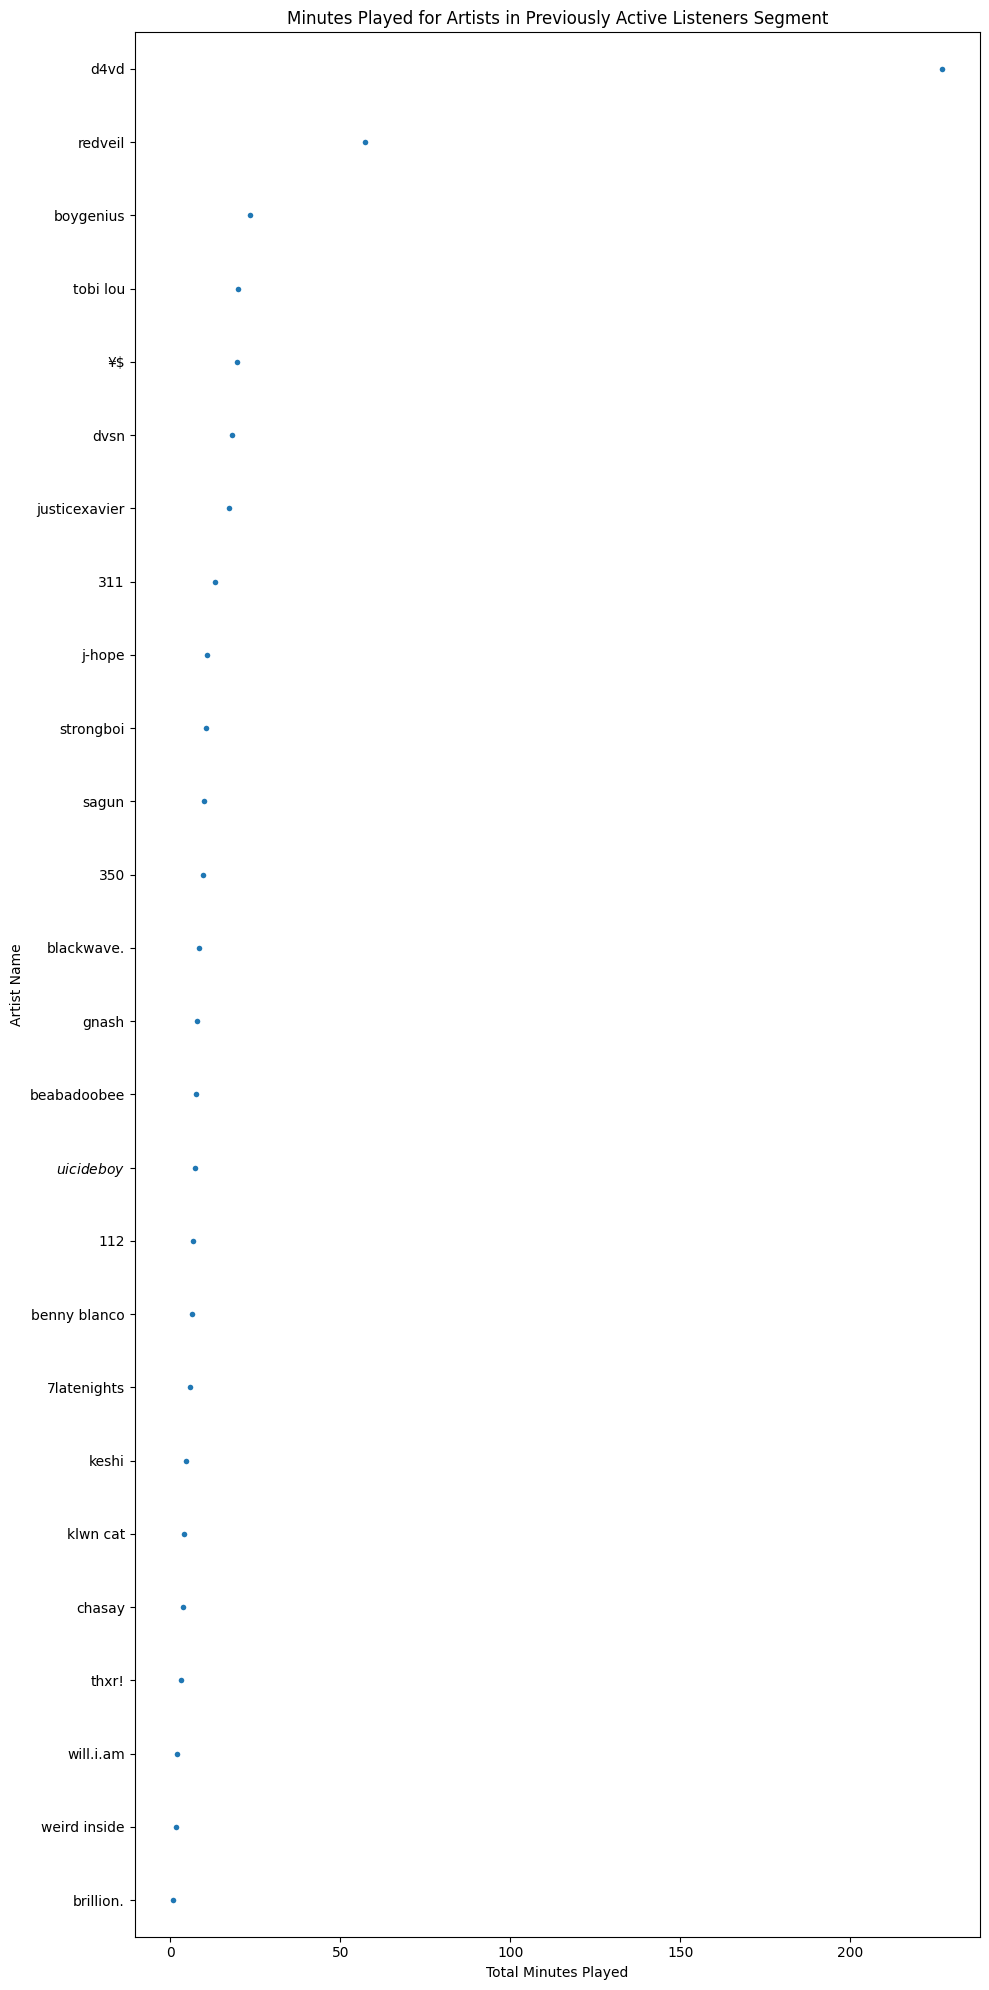

In [21]:

# Sorting by minutesPlayed for a better visual representation
artist_listen_minutes_sorted = artist_listen_minutes.sort_values('minutesPlayed', ascending=False)

plt.figure(figsize=(10, 20))
sns.stripplot(x='minutesPlayed', y='artistName', data=artist_listen_minutes_sorted, size=4, orient='h')
plt.title('Minutes Played for Artists in Previously Active Listeners Segment')
plt.xlabel('Total Minutes Played')
plt.ylabel('Artist Name')
plt.tight_layout()
plt.show()


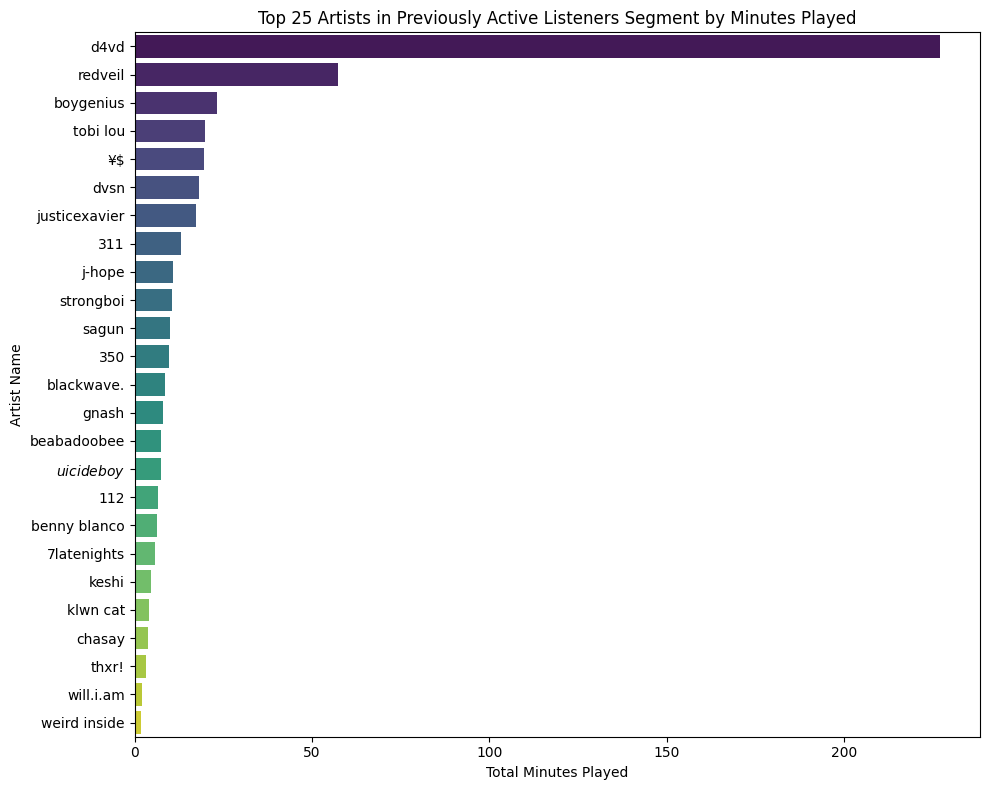

In [22]:
# Focusing on the top 25 artists for clarity
top_25_artists = artist_listen_minutes_sorted.head(25)

plt.figure(figsize=(10, 8))
sns.barplot(x='minutesPlayed', y='artistName', data=top_25_artists, palette='viridis')
plt.title('Top 25 Artists in Previously Active Listeners Segment by Minutes Played')
plt.xlabel('Total Minutes Played')
plt.ylabel('Artist Name')
plt.tight_layout()
plt.show()


In [23]:
merged_df['artistName'] = merged_df['artistName'].str.replace('$', 'S')

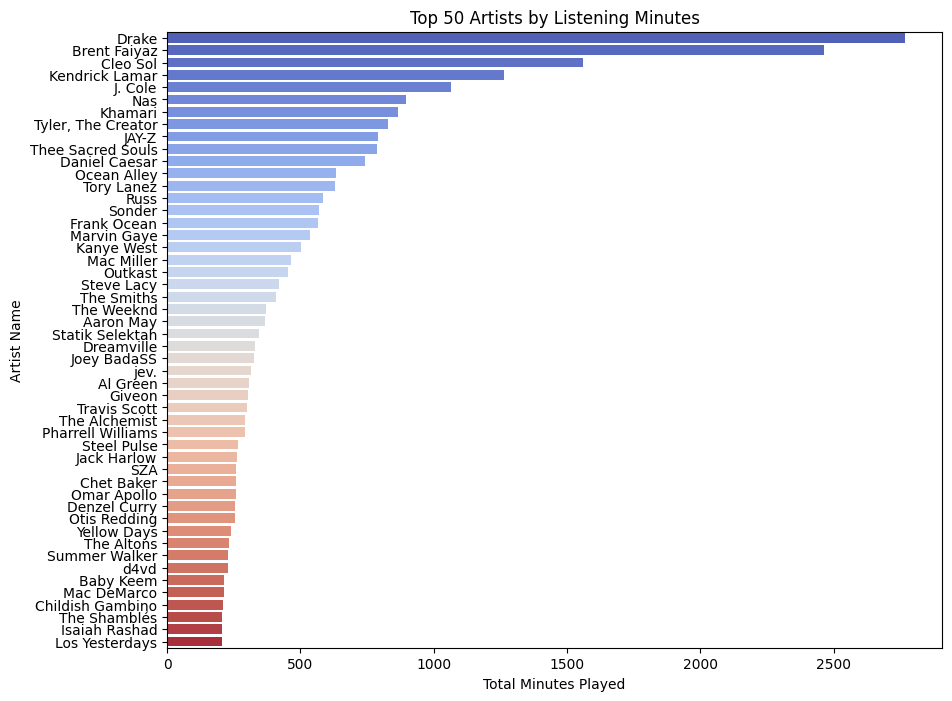

In [24]:
artist_listen_minutes = merged_df.groupby('artistName')['minutesPlayed'].sum().reset_index()
top_50_artists = artist_listen_minutes.sort_values(by='minutesPlayed', ascending=False).head(50)
plt.figure(figsize=(10, 8))
sns.barplot(x='minutesPlayed', y='artistName', data=top_50_artists, palette='coolwarm')
plt.title('Top 50 Artists by Listening Minutes')
plt.xlabel('Total Minutes Played')
plt.ylabel('Artist Name')
plt.show()


In [25]:
from sklearn.preprocessing import MinMaxScaler

# Normalize minutesPlayed for circle sizes
scaler = MinMaxScaler(feature_range=(100, 1000)) # Example size range between 100 and 1000
artist_listen_minutes['circle_sizes'] = scaler.fit_transform(artist_listen_minutes[['minutesPlayed']])


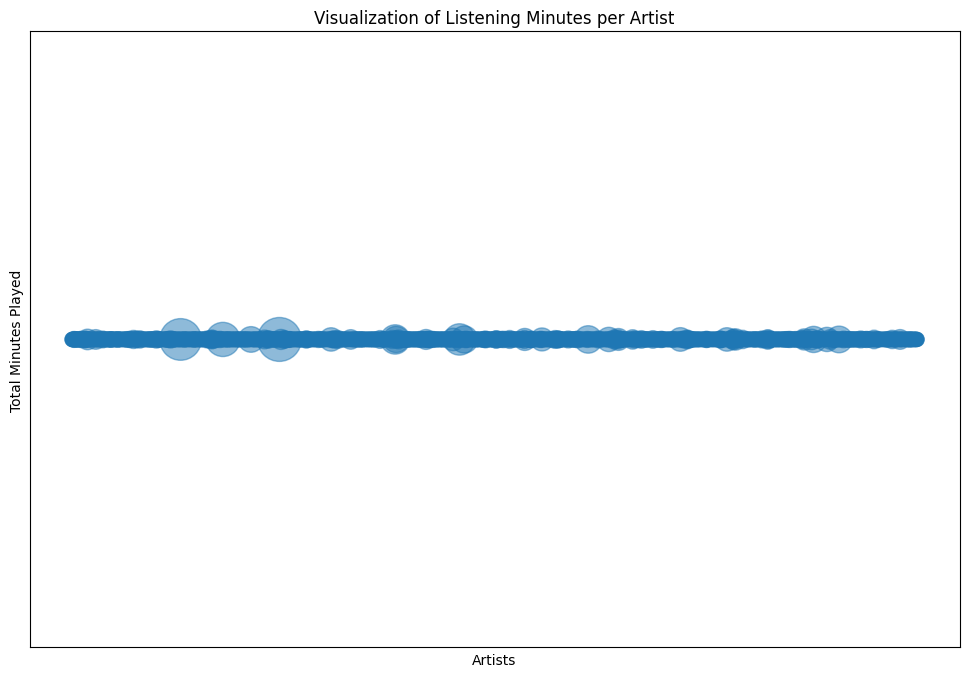

In [26]:
import matplotlib.pyplot as plt

# Generate artist positions on the x-axis
artist_listen_minutes['x_pos'] = range(len(artist_listen_minutes))

plt.figure(figsize=(12, 8))
plt.scatter(artist_listen_minutes['x_pos'], np.zeros(len(artist_listen_minutes)), s=artist_listen_minutes['circle_sizes'], alpha=0.5)

# Optional: Remove y-axis and ticks for clarity, since they don't represent meaningful data in this visualization
plt.yticks([])
plt.xticks([])

plt.title('Visualization of Listening Minutes per Artist')
plt.xlabel('Artists')
plt.ylabel('Total Minutes Played')
plt.show()


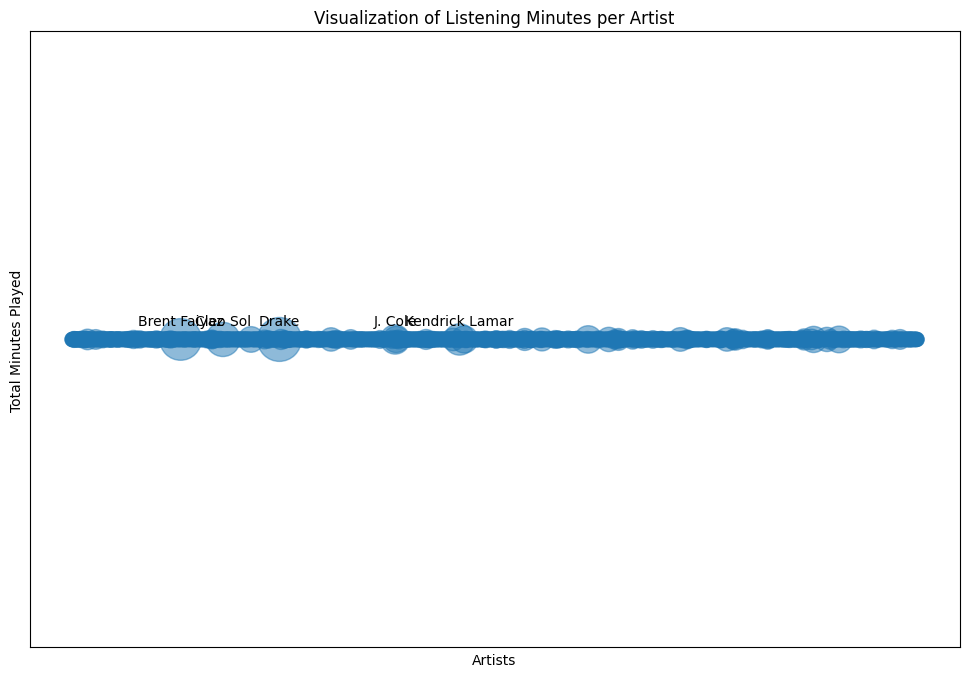

In [27]:
# Find the top N artists for annotation
top_artists = artist_listen_minutes.nlargest(5, 'minutesPlayed')

plt.figure(figsize=(12, 8))
plt.scatter(artist_listen_minutes['x_pos'], np.zeros(len(artist_listen_minutes)), s=artist_listen_minutes['circle_sizes'], alpha=0.5)

# Annotating top artists
for _, row in top_artists.iterrows():
    plt.annotate(row['artistName'], (row['x_pos'], 0), textcoords="offset points", xytext=(0,10), ha='center')

plt.yticks([])
plt.xticks([])
plt.title('Visualization of Listening Minutes per Artist')
plt.xlabel('Artists')
plt.ylabel('Total Minutes Played')
plt.show()


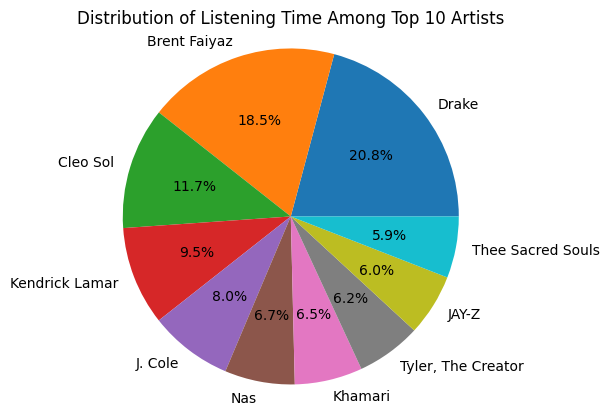

In [28]:
top_artists = artist_listen_minutes.sort_values('minutesPlayed', ascending=False).head(10)
plt.pie(top_artists['minutesPlayed'], labels=top_artists['artistName'], autopct='%1.1f%%')
plt.title('Distribution of Listening Time Among Top 10 Artists')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()


/tmp/ipykernel_18/3677546289.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  streaming_history_df.resample('M')['minutesPlayed'].sum().plot(title='Monthly Listening Time')


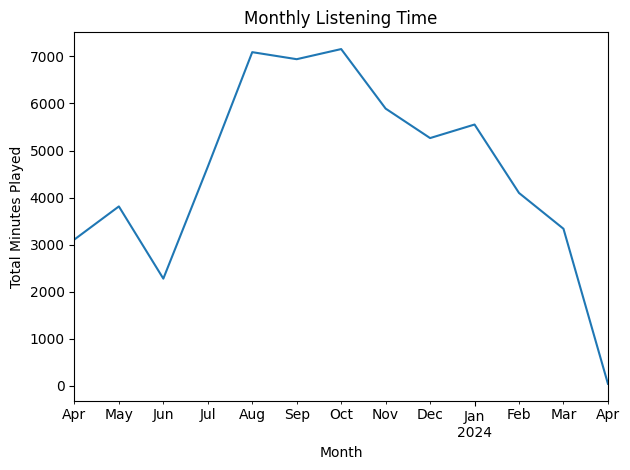

In [29]:
streaming_history_df['endTime'] = pd.to_datetime(streaming_history_df['endTime'])
streaming_history_df.set_index('endTime', inplace=True)
streaming_history_df.resample('M')['minutesPlayed'].sum().plot(title='Monthly Listening Time')
plt.ylabel('Total Minutes Played')
plt.xlabel('Month')
plt.tight_layout()


# When would I listen to music?
Using a 

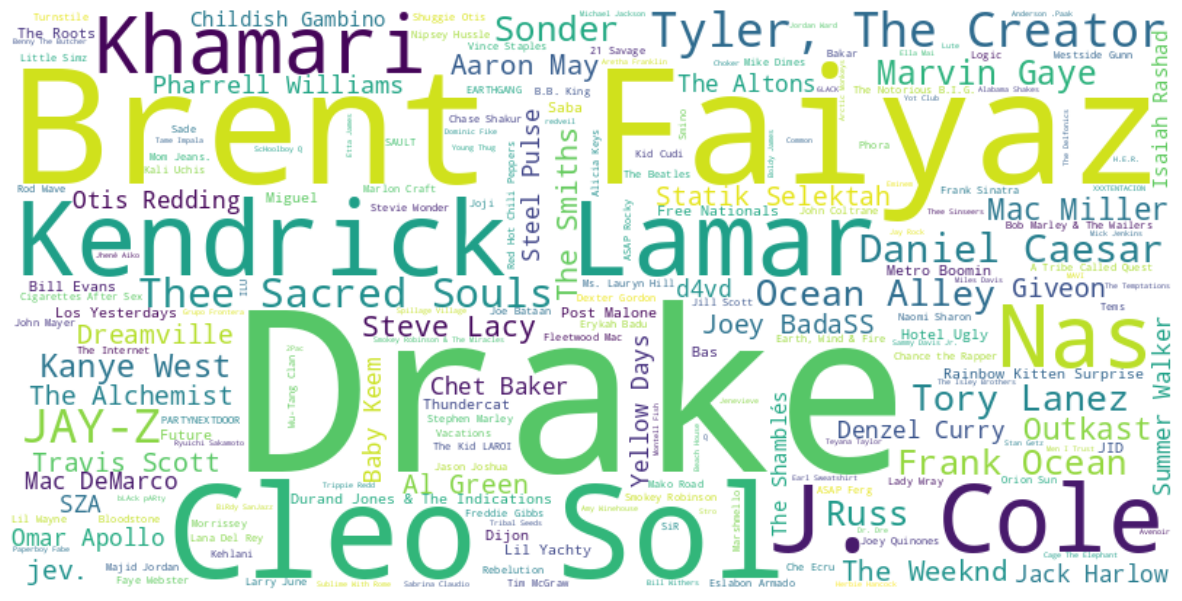

In [30]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(dict(zip(artist_listen_minutes.artistName, artist_listen_minutes.minutesPlayed)))

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

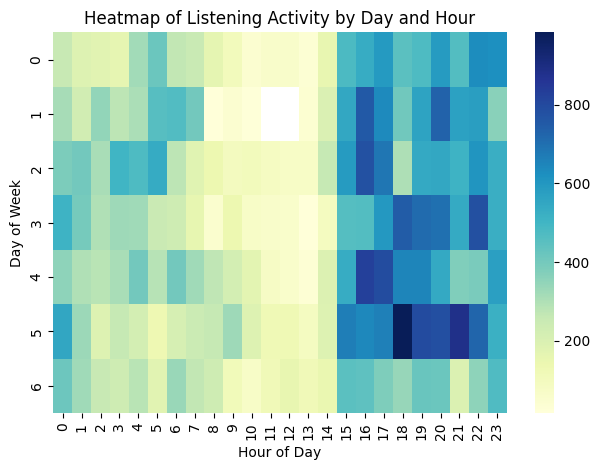

In [31]:
# Extracting day of week and hour from endTime
streaming_history_df['day_of_week'] = streaming_history_df.index.dayofweek
streaming_history_df['hour'] = streaming_history_df.index.hour

# Creating a pivot table
pivot_table = streaming_history_df.pivot_table(index='day_of_week', columns='hour', values='minutesPlayed', aggfunc='sum')

# Plotting
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Heatmap of Listening Activity by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()


In [32]:
streaming_history_df.head()

,artistName,trackName,msPlayed,minutesPlayed,year_month,day_of_week,hour
endTime,,,,,,,
2023-04-01 00:00:00,Brent Faiyaz,"GRAVITY (FEAT. TYLER, THE CREATOR)",2043,0.034050,2023-04,5,0
2023-04-01 00:00:00,Joey Bada$$,Head High,8498,0.141633,2023-04,5,0
2023-04-01 00:00:00,"Tyler, The Creator",Potato Salad,118750,1.979167,2023-04,5,0
2023-04-01 00:03:00,"Tyler, The Creator",STUNTMAN (feat. Vince Staples),188197,3.136617,2023-04,5,0
2023-04-01 00:04:00,"Tyler, The Creator","BOYFRIEND, GIRLFRIEND (2020 Demo) (feat. YG)",33459,0.557650,2023-04,5,0


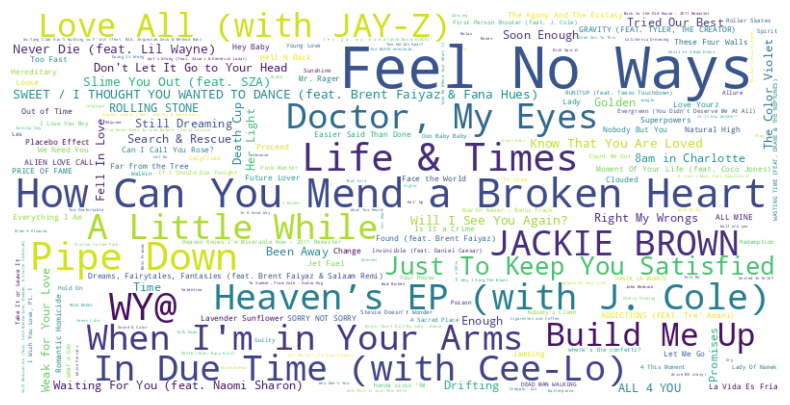

In [33]:
track_minutes = streaming_history_df.groupby('trackName')['minutesPlayed'].sum().reset_index()

# Convert into a dictionary: track names are keys, and total minutes played are values
track_dict = pd.Series(track_minutes.minutesPlayed.values, index=track_minutes.trackName).to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(track_dict)

# Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()
